In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
%matplotlib notebook

In [2]:
df = pd.read_csv(r'./data/FPT.csv')
#cột Date/Time có kiểu giá trị object, chuyển thành datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')

In [3]:
df.tail()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
97401,FPT,2020-12-22 14:24:00,58.2,58.2,58.2,58.2,27470,0
97402,FPT,2020-12-22 14:25:00,58.2,58.2,58.2,58.2,14820,0
97403,FPT,2020-12-22 14:26:00,58.2,58.2,58.2,58.2,500,0
97404,FPT,2020-12-22 14:29:00,58.1,58.1,58.1,58.1,2500,0
97405,FPT,2020-12-22 14:46:00,58.1,58.1,58.1,58.1,11170,0


<IPython.core.display.Javascript object>


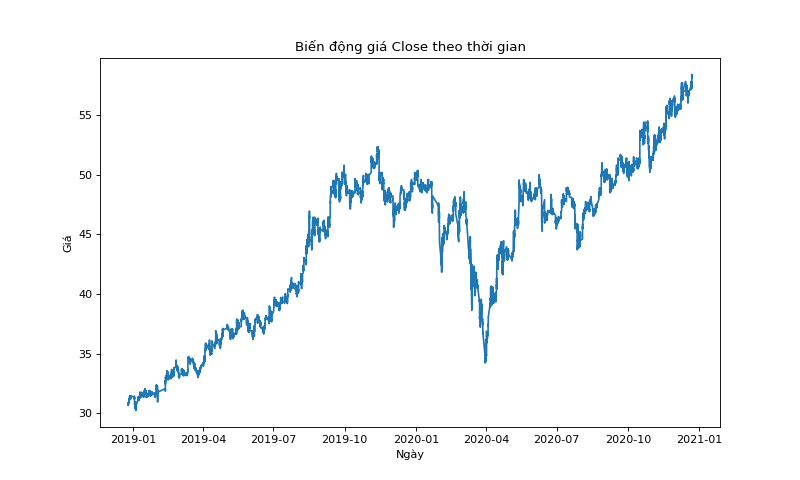

In [4]:
plt.figure(figsize = (10,6))
plt.plot(df['Date/Time'], df['Close'])
plt.title('Biến động giá Close theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.show()

In [5]:
df['Target'] = df['Close'] - df['Open']
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]
df['TargetNextClose'] = df['Close'].shift(-1)
df.dropna(inplace= True)

In [6]:
df.drop(['Ticker','Open Interest','Date/Time'],axis = 1,inplace = True)
df.head()

,Open,High,Low,Close,Volume,Target,TargetClass,TargetNextClose
0,30.89,30.89,30.89,30.89,35410,0.0,0,30.81
1,30.81,30.81,30.81,30.81,190,0.0,0,30.74
2,30.74,30.81,30.74,30.74,1120,0.0,0,30.74
3,30.74,30.74,30.74,30.74,2120,0.0,0,30.74
4,30.74,30.74,30.74,30.74,22500,0.0,0,30.74


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)
print(data_set_scaled)

[[0.02273535 0.02265487 0.02377573 ... 0.31578947 0.         0.01989343]
 [0.01989343 0.01982301 0.02093683 ... 0.31578947 0.         0.01740675]
 [0.01740675 0.01982301 0.0184528  ... 0.31578947 0.         0.01740675]
 ...
 [0.9928952  0.98938053 0.99290277 ... 0.31578947 0.         0.9928952 ]
 [0.9928952  0.98938053 0.99290277 ... 0.31578947 0.         0.98934281]
 [0.98934281 0.98584071 0.98935415 ... 0.31578947 0.         0.98934281]]


In [15]:
# multiple feature from data provided to the model
X = []

backcandles = 200
print(data_set_scaled.shape[0])
for j in range(5):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
# print(X.shape)
# print(y.shape)

97405


In [17]:
y.shape

(97205, 1)

In [35]:
# split data into train test sets
splitlimit = int(len(X)*0.99)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)
print('y_train',y_train)

96232
X_train.shape (96232, 200, 5)
X_test.shape (973, 200, 5)
y_train.shape (96232, 1)
y_test.shape (973, 1)
y_train [[0.03978686]
 [0.03872114]
 [0.03978686]
 ...
 [0.96092362]
 [0.96447602]
 [0.96447602]]


In [36]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

# lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
# inputs = LSTM(250, name='first_layer')(lstm_input)
# inputs = Dense(1, name='dense_layer')(inputs)


model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(backcandles,5)))
model.add(LSTM(units=100))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình trên bộ dữ liệu train
# model.fit(X_train, y_train, epochs=3, batch_size=32)


# output = Activation('linear', name='output')(inputs)
# model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam()
# model.compile(optimizer=adam, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200, 100)          42400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(x=X_train, y=y_train, batch_size=10, epochs=3, shuffle=True,validation_split=0.1)

Epoch 1/3
8661/8661 [==============================] - 171s 19ms/step - loss: 1.1034e-04 - val_loss: 3.0153e-05
Epoch 2/3
8661/8661 [==============================] - 168s 19ms/step - loss: 1.9826e-05 - val_loss: 1.2789e-05
Epoch 3/3
8661/8661 [==============================] - 168s 19ms/step - loss: 1.5658e-05 - val_loss: 1.1034e-04


In [38]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
    
y_new_inverted_pred = y_pred * (df['Close'].max() - df['Close'].min()) + df['Close'].min()
y_new_inverted_test = y_test * (df['Close'].max() - df['Close'].min()) + df['Close'].min()

<IPython.core.display.Javascript object>


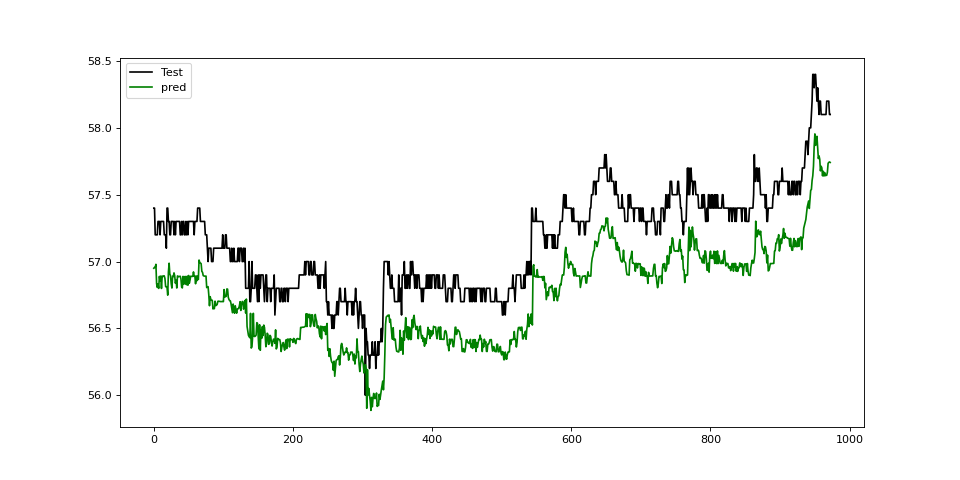

In [46]:
plt.figure(figsize=(12,6))
plt.plot(y_new_inverted_test, color = 'black', label = 'Test')
plt.plot(y_new_inverted_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()